# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :** 

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation. 

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (1 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
from multiprocessing import cpu_count
from PIL import Image
from tqdm import tqdm
from TP4_Transfer_Learning_and_Data_Augmentation import *

_ = torch.manual_seed(0)

MEAN = [0.485, 0.456, 0.406]
STD_DEV = [0.229, 0.224, 0.225]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device.')

def get_dataloader(experiment, batch_size=10, transformations=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=MEAN, std=STD_DEV)])):
    if experiment == 'training':
        dataset = datasets.CIFAR10(root='data/', download=True, transform=transformations)
        train_subset = torch.utils.data.Subset(dataset, range(0, 100))
        dataloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    elif experiment == 'base':
        dataset = datasets.CIFAR10(root='data/', download=True, transform=transformations)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    elif experiment == 'testing':
        dataset = datasets.CIFAR10(root='data/', download=True, train=False, transform=transformations)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    else:
        raise ValueError('Invalid experiment type')
    return dataloader
    

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


Using cuda device.


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


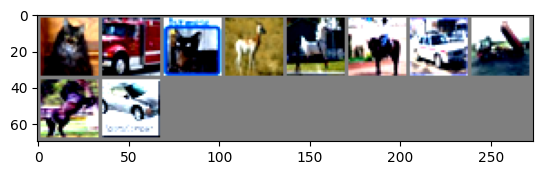

In [13]:
train_dataloader = get_dataloader('training')
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. 

* The remaining samples correspond to $\mathcal{X}$. 

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (0.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. 

## ResNet architectures

__Question 3 (2 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [14]:
def run_epoch(model, dataloader, criterion, optimizer, device, scheduler=None, verbose=True):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(dataloader, disable=not verbose):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    loss = running_loss / len(dataloader.dataset)
    accuracy = running_corrects.double() / len(dataloader.dataset)
    return loss, accuracy

def train(model, dataloader, criterion, optimizer, device, epochs=10, scheduler=None, verbose=True):
    losses = np.zeros(epochs)
    accuracies = np.zeros(epochs)
    for epoch in range(epochs):
        if verbose: print(f'Epoch {epoch}/{epochs - 1}')
        loss, acc = run_epoch(model, dataloader, criterion, optimizer, device, scheduler=scheduler, verbose=verbose)
        losses[epoch] = loss
        accuracies[epoch] = acc
        if verbose: print(f'Finised epoch {epoch}/{epochs - 1}, loss: {loss:.4f}, acc: {acc:.4f}')
    if verbose: print('Finished Training')
    return losses, accuracies

def test(model, dataloader, criterion, device, verbose=True):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(dataloader, disable=not verbose):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    loss = running_loss / len(dataloader.dataset)
    accuracy = running_corrects.double() / len(dataloader.dataset)
    if verbose: print(f'Loss: {loss:.4f} Acc: {accuracy:.4f}')
    return loss, accuracy

In [15]:
lr = 0.001
max_epochs = 20

model = ResNet18().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
train_dataloader = get_dataloader('training')
base_dataloader = get_dataloader('base')
test_dataloader = get_dataloader('testing')

losses, accuracies = train(model, train_dataloader, criterion, optimizer, device, epochs=max_epochs, scheduler=scheduler)
test_loss, test_acc = test(model, test_dataloader, criterion, device)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 0/19


100%|██████████| 10/10 [00:00<00:00, 115.13it/s]


Finised epoch 0/19, loss: 3.1072, acc: 0.0900
Epoch 1/19


100%|██████████| 10/10 [00:00<00:00, 122.35it/s]


Finised epoch 1/19, loss: 2.4168, acc: 0.1200
Epoch 2/19


100%|██████████| 10/10 [00:00<00:00, 125.61it/s]


Finised epoch 2/19, loss: 2.0131, acc: 0.2900
Epoch 3/19


100%|██████████| 10/10 [00:00<00:00, 125.31it/s]


Finised epoch 3/19, loss: 1.5539, acc: 0.4200
Epoch 4/19


100%|██████████| 10/10 [00:00<00:00, 124.87it/s]


Finised epoch 4/19, loss: 1.4277, acc: 0.4800
Epoch 5/19


100%|██████████| 10/10 [00:00<00:00, 123.69it/s]


Finised epoch 5/19, loss: 1.3555, acc: 0.5500
Epoch 6/19


100%|██████████| 10/10 [00:00<00:00, 123.51it/s]


Finised epoch 6/19, loss: 1.3105, acc: 0.5500
Epoch 7/19


100%|██████████| 10/10 [00:00<00:00, 125.18it/s]


Finised epoch 7/19, loss: 1.2296, acc: 0.6800
Epoch 8/19


100%|██████████| 10/10 [00:00<00:00, 125.69it/s]


Finised epoch 8/19, loss: 1.2717, acc: 0.6500
Epoch 9/19


100%|██████████| 10/10 [00:00<00:00, 125.00it/s]


Finised epoch 9/19, loss: 1.2559, acc: 0.6300
Epoch 10/19


100%|██████████| 10/10 [00:00<00:00, 125.36it/s]


Finised epoch 10/19, loss: 1.1988, acc: 0.7000
Epoch 11/19


100%|██████████| 10/10 [00:00<00:00, 126.09it/s]


Finised epoch 11/19, loss: 1.2129, acc: 0.7100
Epoch 12/19


100%|██████████| 10/10 [00:00<00:00, 125.99it/s]


Finised epoch 12/19, loss: 1.2788, acc: 0.6300
Epoch 13/19


100%|██████████| 10/10 [00:00<00:00, 123.93it/s]


Finised epoch 13/19, loss: 1.1989, acc: 0.6800
Epoch 14/19


100%|██████████| 10/10 [00:00<00:00, 125.40it/s]


Finised epoch 14/19, loss: 1.2009, acc: 0.6900
Epoch 15/19


100%|██████████| 10/10 [00:00<00:00, 126.10it/s]


Finised epoch 15/19, loss: 1.2764, acc: 0.6300
Epoch 16/19


100%|██████████| 10/10 [00:00<00:00, 125.20it/s]


Finised epoch 16/19, loss: 1.2371, acc: 0.6300
Epoch 17/19


100%|██████████| 10/10 [00:00<00:00, 125.02it/s]


Finised epoch 17/19, loss: 1.2351, acc: 0.6500
Epoch 18/19


100%|██████████| 10/10 [00:00<00:00, 124.59it/s]


Finised epoch 18/19, loss: 1.2231, acc: 0.6500
Epoch 19/19


100%|██████████| 10/10 [00:00<00:00, 125.35it/s]


Finised epoch 19/19, loss: 1.2127, acc: 0.6900
Finished Training


100%|██████████| 1000/1000 [00:03<00:00, 282.29it/s]

Loss: 2.2510 Acc: 0.2368
Test loss: 2.2510, Test accuracy: 0.2368


# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (1 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [16]:
# we choose a resnet18 model, to be consistent

model = torchvision.models.resnet18(weights='IMAGENET1K_V1').to(device)
# adapt it to cifar
model.fc = nn.Linear(512, 10).to(device)

lr = 0.001
max_epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
losses, accuracies = train(model, train_dataloader, criterion, optimizer, device, epochs=max_epochs, scheduler=scheduler)
test_loss, test_acc = test(model, test_dataloader, criterion, device)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')


Epoch 0/9


100%|██████████| 10/10 [00:00<00:00, 78.02it/s]


Finised epoch 0/9, loss: 2.5817, acc: 0.2200
Epoch 1/9


100%|██████████| 10/10 [00:00<00:00, 128.18it/s]


Finised epoch 1/9, loss: 2.1355, acc: 0.3200
Epoch 2/9


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 124.35it/s]


Finised epoch 2/9, loss: 1.4297, acc: 0.5300
Epoch 3/9


100%|██████████| 10/10 [00:00<00:00, 127.89it/s]


Finised epoch 3/9, loss: 0.9634, acc: 0.7000
Epoch 4/9


100%|██████████| 10/10 [00:00<00:00, 127.19it/s]


Finised epoch 4/9, loss: 0.8561, acc: 0.6900
Epoch 5/9


100%|██████████| 10/10 [00:00<00:00, 127.69it/s]


Finised epoch 5/9, loss: 0.6770, acc: 0.7900
Epoch 6/9


100%|██████████| 10/10 [00:00<00:00, 128.62it/s]


Finised epoch 6/9, loss: 0.6857, acc: 0.8000
Epoch 7/9


100%|██████████| 10/10 [00:00<00:00, 128.95it/s]


Finised epoch 7/9, loss: 0.4879, acc: 0.8000
Epoch 8/9


100%|██████████| 10/10 [00:00<00:00, 129.68it/s]


Finised epoch 8/9, loss: 0.5213, acc: 0.8500
Epoch 9/9


100%|██████████| 10/10 [00:00<00:00, 125.94it/s]


Finised epoch 9/9, loss: 0.5587, acc: 0.7900
Finished Training


100%|██████████| 1000/1000 [00:03<00:00, 276.39it/s]

Loss: 2.4491 Acc: 0.2409
Test loss: 2.4491, Test accuracy: 0.2409


# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks, though one might have to handle several boundary effects.

__Question 5 (0.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

## Data augmentations

__Question 6 (4 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 0/49


100%|██████████| 10/10 [00:00<00:00, 96.80it/s]


Finised epoch 0/49, loss: 2.3666, acc: 0.1700
Epoch 1/49


100%|██████████| 10/10 [00:00<00:00, 99.16it/s]


Finised epoch 1/49, loss: 2.1111, acc: 0.2600
Epoch 2/49


100%|██████████| 10/10 [00:00<00:00, 101.78it/s]


Finised epoch 2/49, loss: 1.8490, acc: 0.3800
Epoch 3/49


100%|██████████| 10/10 [00:00<00:00, 101.79it/s]


Finised epoch 3/49, loss: 1.6728, acc: 0.4100
Epoch 4/49


100%|██████████| 10/10 [00:00<00:00, 102.86it/s]


Finised epoch 4/49, loss: 1.5580, acc: 0.4700
Epoch 5/49


100%|██████████| 10/10 [00:00<00:00, 102.00it/s]


Finised epoch 5/49, loss: 1.5011, acc: 0.4200
Epoch 6/49


100%|██████████| 10/10 [00:00<00:00, 96.38it/s]


Finised epoch 6/49, loss: 1.4181, acc: 0.4900
Epoch 7/49


100%|██████████| 10/10 [00:00<00:00, 100.74it/s]


Finised epoch 7/49, loss: 1.2398, acc: 0.5500
Epoch 8/49


100%|██████████| 10/10 [00:00<00:00, 102.62it/s]


Finised epoch 8/49, loss: 1.3741, acc: 0.5300
Epoch 9/49


100%|██████████| 10/10 [00:00<00:00, 100.98it/s]


Finised epoch 9/49, loss: 1.4254, acc: 0.5100
Epoch 10/49


100%|██████████| 10/10 [00:00<00:00, 102.18it/s]


Finised epoch 10/49, loss: 1.2369, acc: 0.5600
Epoch 11/49


100%|██████████| 10/10 [00:00<00:00, 101.58it/s]


Finised epoch 11/49, loss: 1.1368, acc: 0.6300
Epoch 12/49


100%|██████████| 10/10 [00:00<00:00, 102.15it/s]


Finised epoch 12/49, loss: 1.1030, acc: 0.6000
Epoch 13/49


100%|██████████| 10/10 [00:00<00:00, 101.94it/s]


Finised epoch 13/49, loss: 0.9080, acc: 0.6800
Epoch 14/49


100%|██████████| 10/10 [00:00<00:00, 102.25it/s]


Finised epoch 14/49, loss: 0.8738, acc: 0.7000
Epoch 15/49


100%|██████████| 10/10 [00:00<00:00, 101.66it/s]


Finised epoch 15/49, loss: 0.9651, acc: 0.6900
Epoch 16/49


100%|██████████| 10/10 [00:00<00:00, 102.25it/s]


Finised epoch 16/49, loss: 0.8240, acc: 0.7200
Epoch 17/49


100%|██████████| 10/10 [00:00<00:00, 101.91it/s]


Finised epoch 17/49, loss: 0.8449, acc: 0.6800
Epoch 18/49


100%|██████████| 10/10 [00:00<00:00, 102.19it/s]


Finised epoch 18/49, loss: 0.9490, acc: 0.6400
Epoch 19/49


100%|██████████| 10/10 [00:00<00:00, 101.57it/s]


Finised epoch 19/49, loss: 0.7825, acc: 0.7400
Epoch 20/49


100%|██████████| 10/10 [00:00<00:00, 101.97it/s]


Finised epoch 20/49, loss: 0.7594, acc: 0.7400
Epoch 21/49


100%|██████████| 10/10 [00:00<00:00, 102.21it/s]


Finised epoch 21/49, loss: 0.7348, acc: 0.8000
Epoch 22/49


100%|██████████| 10/10 [00:00<00:00, 102.25it/s]


Finised epoch 22/49, loss: 0.6847, acc: 0.7800
Epoch 23/49


100%|██████████| 10/10 [00:00<00:00, 102.42it/s]


Finised epoch 23/49, loss: 0.7607, acc: 0.7100
Epoch 24/49


100%|██████████| 10/10 [00:00<00:00, 102.23it/s]


Finised epoch 24/49, loss: 0.6169, acc: 0.8100
Epoch 25/49


100%|██████████| 10/10 [00:00<00:00, 102.25it/s]


Finised epoch 25/49, loss: 0.6288, acc: 0.7900
Epoch 26/49


100%|██████████| 10/10 [00:00<00:00, 102.31it/s]


Finised epoch 26/49, loss: 0.6888, acc: 0.7700
Epoch 27/49


100%|██████████| 10/10 [00:00<00:00, 102.59it/s]


Finised epoch 27/49, loss: 0.4717, acc: 0.8300
Epoch 28/49


100%|██████████| 10/10 [00:00<00:00, 102.32it/s]


Finised epoch 28/49, loss: 0.5755, acc: 0.7700
Epoch 29/49


100%|██████████| 10/10 [00:00<00:00, 101.17it/s]


Finised epoch 29/49, loss: 0.5263, acc: 0.8300
Epoch 30/49


100%|██████████| 10/10 [00:00<00:00, 102.52it/s]


Finised epoch 30/49, loss: 0.4181, acc: 0.9200
Epoch 31/49


100%|██████████| 10/10 [00:00<00:00, 101.77it/s]


Finised epoch 31/49, loss: 0.4922, acc: 0.8400
Epoch 32/49


100%|██████████| 10/10 [00:00<00:00, 102.21it/s]


Finised epoch 32/49, loss: 0.5854, acc: 0.8000
Epoch 33/49


100%|██████████| 10/10 [00:00<00:00, 102.54it/s]


Finised epoch 33/49, loss: 0.4691, acc: 0.8300
Epoch 34/49


100%|██████████| 10/10 [00:00<00:00, 102.72it/s]


Finised epoch 34/49, loss: 0.4520, acc: 0.8900
Epoch 35/49


100%|██████████| 10/10 [00:00<00:00, 101.89it/s]


Finised epoch 35/49, loss: 0.3850, acc: 0.8700
Epoch 36/49


100%|██████████| 10/10 [00:00<00:00, 101.59it/s]


Finised epoch 36/49, loss: 0.3275, acc: 0.8800
Epoch 37/49


100%|██████████| 10/10 [00:00<00:00, 102.00it/s]


Finised epoch 37/49, loss: 0.3917, acc: 0.8700
Epoch 38/49


100%|██████████| 10/10 [00:00<00:00, 102.00it/s]


Finised epoch 38/49, loss: 0.3996, acc: 0.8700
Epoch 39/49


100%|██████████| 10/10 [00:00<00:00, 100.72it/s]


Finised epoch 39/49, loss: 0.3695, acc: 0.8700
Epoch 40/49


100%|██████████| 10/10 [00:00<00:00, 103.20it/s]


Finised epoch 40/49, loss: 0.3999, acc: 0.9000
Epoch 41/49


100%|██████████| 10/10 [00:00<00:00, 99.16it/s]


Finised epoch 41/49, loss: 0.5272, acc: 0.8200
Epoch 42/49


100%|██████████| 10/10 [00:00<00:00, 101.15it/s]


Finised epoch 42/49, loss: 0.3801, acc: 0.9200
Epoch 43/49


100%|██████████| 10/10 [00:00<00:00, 101.30it/s]


Finised epoch 43/49, loss: 0.3054, acc: 0.9400
Epoch 44/49


100%|██████████| 10/10 [00:00<00:00, 101.93it/s]


Finised epoch 44/49, loss: 0.5221, acc: 0.8100
Epoch 45/49


100%|██████████| 10/10 [00:00<00:00, 101.05it/s]


Finised epoch 45/49, loss: 0.4972, acc: 0.8400
Epoch 46/49


100%|██████████| 10/10 [00:00<00:00, 94.40it/s]


Finised epoch 46/49, loss: 0.4922, acc: 0.8600
Epoch 47/49


100%|██████████| 10/10 [00:00<00:00, 98.40it/s]


Finised epoch 47/49, loss: 0.5890, acc: 0.8700
Epoch 48/49


100%|██████████| 10/10 [00:00<00:00, 101.17it/s]


Finised epoch 48/49, loss: 0.3458, acc: 0.8800
Epoch 49/49


100%|██████████| 10/10 [00:00<00:00, 101.91it/s]


Finised epoch 49/49, loss: 0.3451, acc: 0.8900
Finished Training


100%|██████████| 1000/1000 [00:05<00:00, 184.41it/s]


Loss: 3.8566 Acc: 0.2214


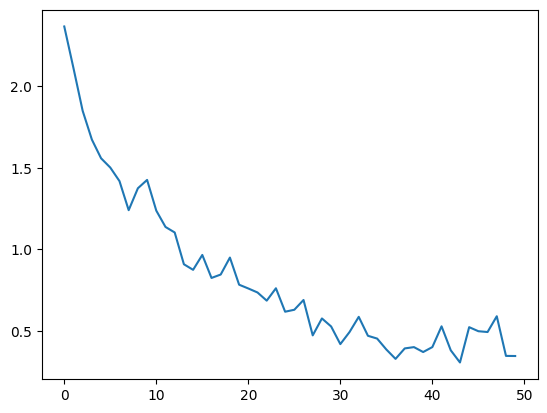

Test loss: 3.8566, Test accuracy: 0.2214


In [17]:
transformations = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomVerticalFlip(p=0.5),
                                 #transforms.RandomSolarize(0.5, p=0.5),
                                 transforms.RandomRotation(20),
                                 transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=MEAN, std=STD_DEV)])

train_dataloader = get_dataloader('training', transformations=transformations)
base_dataloader = get_dataloader('base', transformations=transformations)
test_dataloader = get_dataloader('testing', transformations=transformations)

lr = 0.0001
max_epochs = 50

model = ResNet18().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = None#torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
criterion = torch.nn.CrossEntropyLoss()
losses, accuracies = train(model, train_dataloader, criterion, optimizer, device, epochs=max_epochs, scheduler=scheduler)
test_loss, test_acc = test(model, test_dataloader, criterion, device)

plt.plot(losses, label='training loss')
plt.show()
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')

# Conclusions

__Question 7 (3 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

In [18]:
def train_vae(model, dataloader, criterion, optimizer, device, epochs=10, scheduler=None):
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs - 1}')
        model.train()
        running_loss = 0.0
        for inputs, _ in tqdm(dataloader):
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            running_loss += loss.item()
        loss = running_loss / len(dataloader.dataset)
        print(f'Finised epoch {epoch}/{epochs - 1}, loss: {loss:.4f}')
        losses[epoch] = loss
    return losses

In [19]:
# train the VAE
lr = 0.001
max_epochs = 10

vae = VariationalAutoencoder().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = vae_loss
losses = train_vae(vae, get_dataloader('base', batch_size=64), criterion, optimizer, device, epochs=max_epochs, scheduler=scheduler)


Files already downloaded and verified
Epoch 0/9


100%|██████████| 782/782 [00:36<00:00, 21.41it/s]


Finised epoch 0/9, loss: 3209.6040
Epoch 1/9


100%|██████████| 782/782 [00:36<00:00, 21.43it/s]


Finised epoch 1/9, loss: 3153.8430
Epoch 2/9


100%|██████████| 782/782 [00:36<00:00, 21.45it/s]


Finised epoch 2/9, loss: 3153.9382
Epoch 3/9


100%|██████████| 782/782 [00:36<00:00, 21.39it/s]


Finised epoch 3/9, loss: 3153.1726
Epoch 4/9


100%|██████████| 782/782 [00:36<00:00, 21.43it/s]


Finised epoch 4/9, loss: 3153.8687
Epoch 5/9


100%|██████████| 782/782 [00:36<00:00, 21.44it/s]


Finised epoch 5/9, loss: 3153.1453
Epoch 6/9


100%|██████████| 782/782 [00:36<00:00, 21.43it/s]


Finised epoch 6/9, loss: 3153.8563
Epoch 7/9


100%|██████████| 782/782 [00:36<00:00, 21.47it/s]


Finised epoch 7/9, loss: 3153.4808
Epoch 8/9


100%|██████████| 782/782 [00:36<00:00, 21.50it/s]


Finised epoch 8/9, loss: 3153.7886
Epoch 9/9


100%|██████████| 782/782 [00:36<00:00, 21.49it/s]

Finised epoch 9/9, loss: 3152.9009


In [20]:
class WeaklySupervisedModel(torch.nn.Module):
    def __init__(self, vae, classifier):
        super(WeaklySupervisedModel, self).__init__()
        self.encoder = vae.encoder
        self.classifier = classifier
    
    def forward(self, x):
        z = self.encoder(x)
        return self.classifier(z)

In [ ]:
weakly_model = WeaklySupervisedModel(vae, model).to(device)

lr = 0.001
max_epochs = 10
optimizer = torch.optim.Adam(weakly_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
losses, accuracies = train(weakly_model, get_dataloader('training'), criterion, optimizer, device, epochs=max_epochs, scheduler=scheduler)
test_loss, test_acc = test(weakly_model, get_dataloader('testing'), criterion, device)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')